In [ ]:
%pip install transformers

In [ ]:
%pip install datasets

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import transformers
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import DistilBertTokenizerFast
import datasets
from transformers import TFAutoModelForSequenceClassification
from transformers import TFDistilBertForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from IPython.display import clear_output

In [5]:
news_df = pd.read_csv("ft_data.csv", index_col=0)
news_df

,sentiment,headlines
0,0,The international electronic industry company ...
1,1,With the new production plant the company woul...
2,1,According to the company 's updated strategy f...
3,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
4,1,"For the last quarter of 2010 , Componenta 's n..."
...,...,...
1962,0,HELSINKI Thomson Financial - Shares in Cargote...
1963,0,LONDON MarketWatch Share prices ended lower i...
1964,0,Operating profit fell to EUR 35.4 mn from EUR ...
1965,0,Net sales of the Paper segment decreased to EU...


In [5]:
news_df.shape

(1967, 2)

In [6]:
X = list(news_df['headlines'])
y = list(news_df['sentiment'])

In [7]:
train_x, val_x, train_y, val_y = train_test_split(X, 
                                                  y, 
                                                  test_size=0.2, 
                                                  stratify=y,
                                                  random_state=123)

train_x, test_x, train_y, test_y = train_test_split(train_x, 
                                                    train_y, 
                                                    test_size=0.1, 
                                                    stratify=train_y,
                                                    random_state=123)

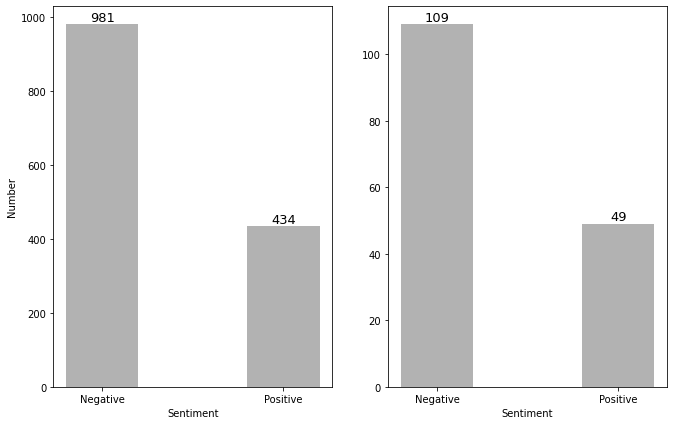

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (11,7))
# Plot the bar graph
plt.subplot(1, 2, 1)
y_axis1 = list(pd.DataFrame(train_y).value_counts())
x_axis1 = ["Negative", "Positive"]

plot1 = plt.bar(x_axis1,
                y_axis1,
                width = 0.4,
                color = "grey",
                alpha = 0.6)
plt.xlabel('Sentiment')
plt.ylabel('Number')
# Add the data value on head of the bar
for value in plot1:
  height = value.get_height()
  plt.text(value.get_x() + value.get_width()/2.,
           1.002*height,'%d' % int(height), ha='center', va='bottom', 
           fontsize = 13)


plt.subplot(1, 2, 2)
y_axis2 = list(pd.DataFrame(test_y).value_counts())
x_axis2 = ["Negative", "Positive"]

plot2 = plt.bar(x_axis2,
                y_axis2,
                width = 0.4,
                color = "grey",
                alpha = 0.6)
plt.xlabel('Sentiment')
# Add the data value on head of the bar
for value in plot2:
  height = value.get_height()
  plt.text(value.get_x() + value.get_width()/2.,
           1.002*height,'%d' % int(height), ha='center', va='bottom', 
           fontsize = 13)

# Display the graph on the screen
plt.show()

In [ ]:
test_export.to_csv("./test_export.csv", index=True, header = True)

## -------------------------------------



In [9]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
train_encodings = tokenizer(train_x,
                            truncation = True,
                            padding = True)

val_encodings = tokenizer(val_x,
                          truncation = True,
                          padding = True)

In [11]:
train_df = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
))

val_df = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
))

In [12]:
model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [13]:
batch_size = 8
num_epochs = 20
start_rate = 0.01
end_rate = 1e-5
power = 0.5
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs
decay_steps = len(train_x)/batch_size * num_epochs

lr_scheduler = PolynomialDecay(
    initial_learning_rate = start_rate, 
    end_learning_rate = end_rate, 
    decay_steps = decay_steps,
    power = power
)

In [14]:
# Compile and train the model with keras
#SparseCategoricalCrossentropy(from_logits=True)
#model.compute_loss
#'sparse_categorical_accuracy'
config = {'loss':SparseCategoricalCrossentropy(from_logits=True),
          'optimizer':Adam(learning_rate=5e-5), 
          'epoch':20,
          'batch_size':8, 
          'metric':'sparse_categorical_accuracy',
          'verbose':1}

model.compile(
    optimizer = config["optimizer"],
    loss = config["loss"],
    metrics = config["metric"]
)

model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Customized Callback
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.metric = []
        self.val_metric = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.metric.append(logs.get('sparse_categorical_accuracy'))
        self.val_metric.append(logs.get('val_sparse_categorical_accuracy'))
        self.i += 1
        
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        fig.set_size_inches(10.5, 7.5)
        fig.suptitle('Processing',size = 20)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="Train Loss")
        ax1.plot(self.x, self.val_losses, label="Valid Loss")
        ax1.legend()
        
        
        ax2.plot(self.x, self.metric, label="Train_accuracy")
        ax2.plot(self.x, self.val_metric, label="Valid_accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

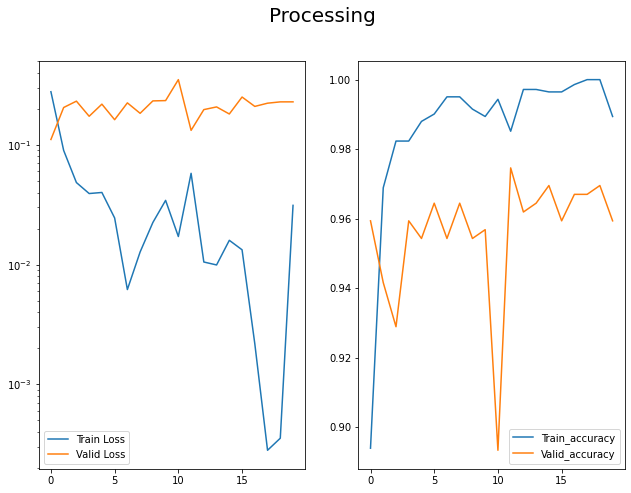

177/177 [==============================] - 12s 68ms/step - loss: 0.0312 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.2290 - val_sparse_categorical_accuracy: 0.9594


In [16]:
model.fit(train_df.batch(8), 
          validation_data = val_df.batch(8), 
          epochs=config['epoch'],
          batch_size =config['batch_size'],
          callbacks=[plot])
          

In [17]:
pred = model.predict(val_df)
class_pred = np.argmax(pred["logits"], axis=1)

## Save the Model

In [19]:
model_dir = './results'
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json',
 './results/tokenizer.json')

## Evaluate Model on Test Set

In [20]:
model_dir = './results'
loaded_tokenizer = DistilBertTokenizerFast.from_pretrained(model_dir)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_dir)

Some layers from the model checkpoint at ./results were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./results and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
predict_list = []
output_list = []
prediction_list =[]

for i in range(len(test_x)):
    predict_input = loaded_tokenizer.encode(test_x[i],
                                     truncation=True,
                                     padding=True,
                                     return_tensors="tf")
    predict_list.append(predict_input)
    

for predict_input in predict_list:
    output = loaded_model(predict_input)[0]
    output_list.append(output)

for z in range(len(output_list)):
    prediction_value = tf.argmax(output_list[z], axis=1).numpy()[0]
    prediction_list.append(prediction_value)

In [36]:
y_pred = prediction_list
y_true = test_y

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Accuracy: %.3f " %(acc))
print("F1-Score: %.3f " %(f1))

Accuracy: 0.937 
F1-Score: 0.953 
